cnsts.shape=(98758, 100, 3)


jets.shape=(98758, 3)


The smallest jet_pt is: 450.00129118847076
The biggest jet_pt is: 999.8620172940161


number of particles loaded: 5365439
number of particles with R=0: 1
percentage of particles with R=0: 0.0%
number of particles with R>=1.0: 14630
percentage of particles with R>=1.0: 0.273%


num_pt_bins=55


num_R_bins=99


hist_cov of bin 0/54 in progress..
hist_cov of bin 1/54 in progress..
hist_cov of bin 2/54 in progress..
hist_cov of bin 3/54 in progress..
hist_cov of bin 4/54 in progress..
hist_cov of bin 5/54 in progress..
hist_cov of bin 6/54 in progress..
hist_cov of bin 7/54 in progress..
hist_cov of bin 8/54 in progress..
hist_cov of bin 9/54 in progress..
hist_cov of bin 10/54 in progress..
hist_cov of bin 11/54 in progress..
hist_cov of bin 12/54 in progress..
hist_cov of bin 13/54 in progress..
hist_cov of bin 14/54 in progress..
hist_cov of bin 15/54 in progress..
hist_cov of bin 16/54 in progress..
hist_cov of bin 17/54 in progress

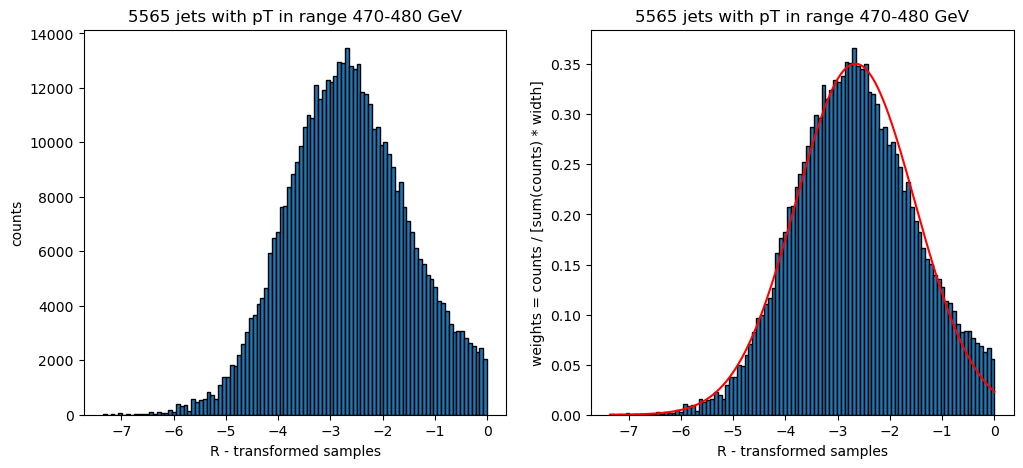

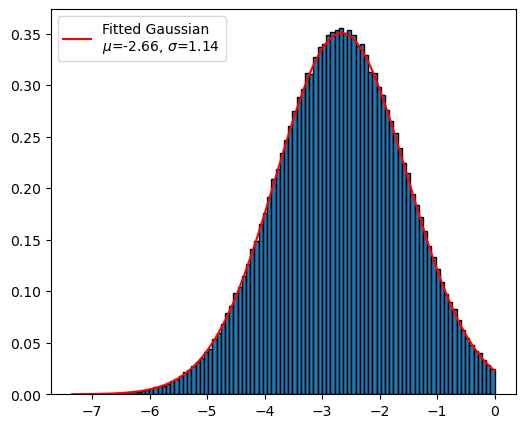

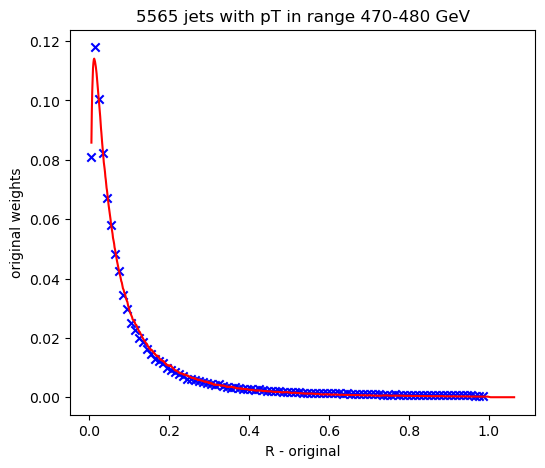

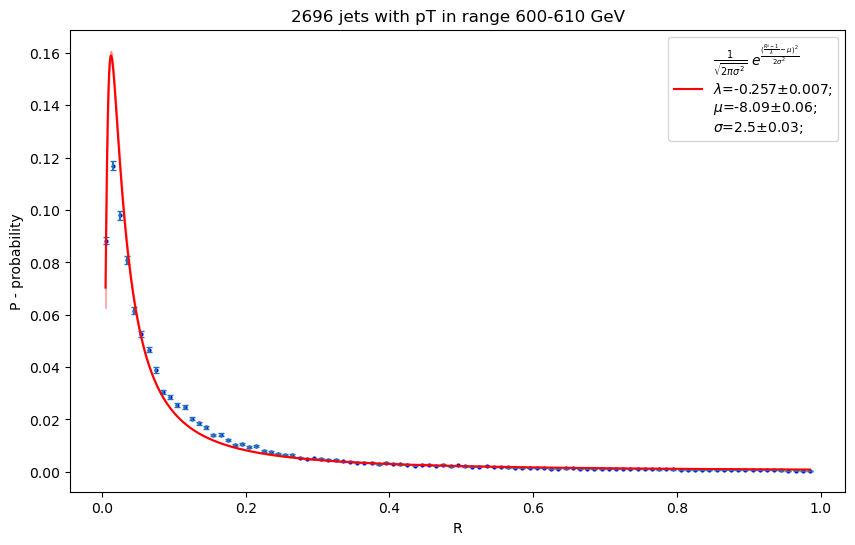

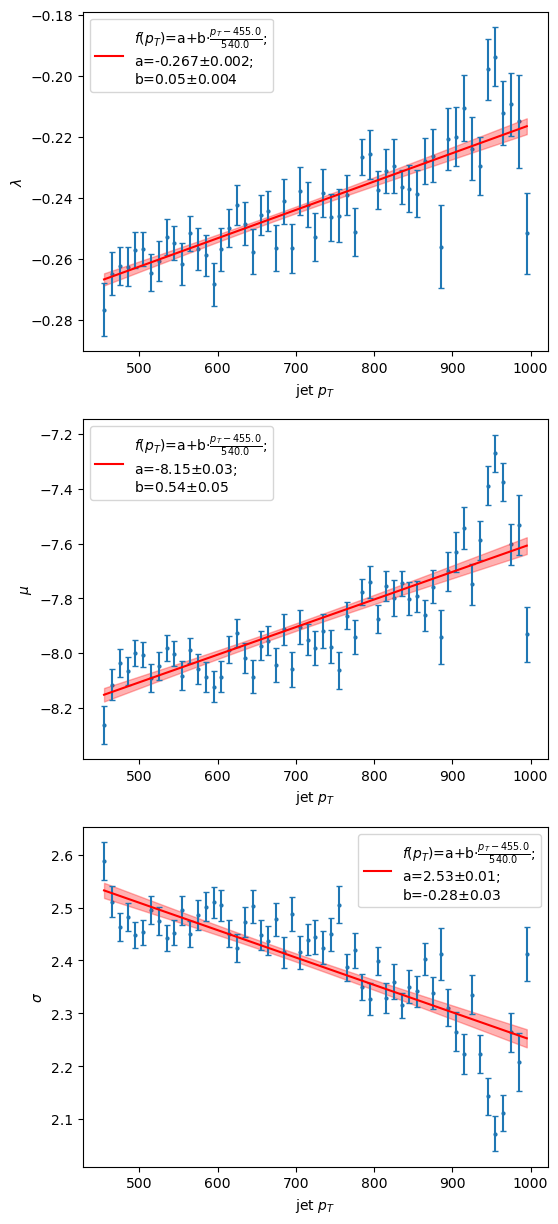

In [1]:
import sys
sys.path.append("./")

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from data_inspect import *
from inspect import signature
from scipy.stats import norm,boxcox
from scipy.special import inv_boxcox
from scipy.optimize import curve_fit

# **SETTING THE DATA STRUCTURE:**

# The input HDF5 file containing the relevant jets:
input = "QCDjj_pT_450_1200_train01.h5" #change if needed

# The number of jets to load:
n_jets = 100_000 #change if needed

# Jet pt range:
min_pt=450 #change if needed
max_pt=1000 #change if needed
width_pt=10

# Choosing only the jets from the set jet pt range
with h5py.File(input, "r") as f:
    
    mask_pt=[index for index,value in enumerate(
        f["objects/jets/jet1_obs"][:n_jets,0]) 
             if ((value>=min_pt) and (value<=max_pt))]

R_max=1.0
width=0.01

jets=read_data(input,mask_pt)

#-------------------------------------------------------------------------------

# **R DISTRIBUTION OF JETS:**

#phi angle differences between the constituents and the associated jet:
#rows -> jets ; columns -> particles
delta_phi=jets['jet_phi'].reshape(-1,1)-jets['part_phi']

#because the phi angle difference should be inside [-np.pi,+np.pi]:
delta_phi_new=np.ma.mod(delta_phi+np.pi,2*np.pi)-np.pi

#eta angle differences between the constituents and the associated jet:
#rows -> jets ; columns -> particles
delta_eta=jets['jet_eta'].reshape(-1,1)-jets['part_eta']

#rows -> jets ; columns -> particles
R=np.ma.sqrt(delta_eta**2+delta_phi_new**2)
    
print(f"number of particles loaded: \
{len(R.compressed())}")

print(f"number of particles with R=0: \
{len(np.where(R.compressed()==0.0)[0])}")

print(f"percentage of particles with R=0: \
{np.round(len(np.where(R.compressed()==0.0)[0])*100/len(R.compressed()),3)}%")

print(f"number of particles with R>={R_max}: \
{len(np.where(R.compressed()>=R_max)[0])}")

print(f"percentage of particles with R>={R_max}: \
{np.round(len(np.where(R.compressed()>=R_max)[0])*100/len(R.compressed()),3)}%")
    
print(f"\n")
    
jets['part_pt']=np.ma.masked_where(R<0,jets['part_pt'])
jets['part_pt']=np.ma.masked_where(R>=R_max,jets['part_pt'])

R=np.ma.masked_where(R<0,R)
R=np.ma.masked_where(R>=R_max,R)
    
#-------------------------------------------------------------------------------

# **SETTING pT BINS:**

bins_pt=np.arange(min_pt,max_pt+width_pt,width_pt)
pt_middles = (bins_pt[1:]+bins_pt[:-1])/2.
num_pt_bins=len(pt_middles)

print(f"num_pt_bins={num_pt_bins}")
print(f"\n")

#-------------------------------------------------------------------------------
    
# **SETTING R BINS:**

bins_r=np.arange(0,R_max,width)
R_middles = (bins_r[1:]+bins_r[:-1])/2.
num_R_bins=len(R_middles)

print(f"num_R_bins={num_R_bins}")
print(f"\n",flush=True)

#-------------------------------------------------------------------------------

mask_binpt=[]

for k in range(num_pt_bins):

        mask_binpt.append([index for index,value in enumerate(
            jets['jet_pt']) if ((value>bins_pt[k]) 
                                and (value<=bins_pt[k+1]))])
        
num_jets=[len(sublist) for sublist in mask_binpt]
        
#-------------------------------------------------------------------------------

# **CREATING THE HISTOGRAMS AND CALCULATING THEIR COVARIANCE MATRICES:**

hist=np.zeros([num_pt_bins,num_R_bins])
cov_matrix=np.zeros([num_pt_bins,num_R_bins,num_R_bins])

for idx in range(num_pt_bins):
    
    print(f"hist_cov of bin {idx}/{num_pt_bins-1} in progress..")

    weights=jets['part_pt'][mask_binpt[idx]]

    hist[idx],cov_matrix[idx]=hist_cov(R[mask_binpt[idx]],bins_r,weights)
    
print(f"\n")

#-------------------------------------------------------------------------------

# **SAMPLING:**

idx=2

weights=jets['part_pt'][mask_binpt[idx]]
weights=weights/(num_jets[idx]*np.sum(weights,axis=1).reshape(-1,1))

n_samples = 500000
data = np.random.choice(R[mask_binpt[idx]].compressed(),
                        size=n_samples,p=weights.compressed())

#-------------------------------------------------------------------------------

# **TRANSFORMING SAMPLED R, PLOTTING IT AND FITING:**

# Transforming:
data_trans,best_lambda = boxcox(data) 

if not os.path.exists("./Plots"):
        os.makedirs("./Plots")

fig,ax=plt.subplots(1,2,figsize=(12,5))

ax[0].set_title(f"{num_jets[idx]} jets with pT in range "
                f"{bins_pt[idx]}-{bins_pt[idx+1]} GeV")
ax[0].hist(data_trans,bins=len(bins_r),ec='black')
ax[0].set_xlabel("R - transformed samples")
ax[0].set_ylabel("counts")

# Fitting a Gaussian:
x=np.linspace(min(data_trans.flatten()),max(data_trans.flatten()),10000)
mu,sigma = norm.fit(data_trans)
pdf = norm.pdf(x,loc=mu,scale=sigma)

ax[1].set_title(f"{num_jets[idx]} jets with pT in range "
                f"{bins_pt[idx]}-{bins_pt[idx+1]} GeV")
ax[1].plot(x,pdf,'r-')
ax[1].hist(data_trans,bins=len(bins_r),ec='black',density=True)
ax[1].set_xlabel("R - transformed samples")
ax[1].set_ylabel("weights = counts / [sum(counts) * width]")

fig.savefig("./Plots/trans_boxcox.jpg")

#-------------------------------------------------------------------------------

# **SAMPLING FROM THE GAUSSIAN:**

prob=pdf/np.sum(pdf)
samples = np.random.choice(x,size=n_samples,p=prob)

plt.figure(figsize=(6,5))
plt.hist(samples,bins=len(bins_r),density=True,ec='black')
label="Fitted Gaussian"
label+=f"\n"
label+=fr"$\mu$={mu:.2f}, $\sigma$={sigma:.2f}"
plt.plot(x,pdf,'r-',label=label)
plt.legend()
plt.savefig(f"./Plots/samples_boxcox.jpg")

#-------------------------------------------------------------------------------

# **TRASNFORMING THE FIT BACK TO THE ORIGINAL SPACE**:

samples_back = inv_boxcox(samples,best_lambda)

hist_fit=[]
middles_fit=[]

# Making the fit as smooth as possible
dif=0.001
a=1/n_samples*np.ones(shape=n_samples)
for i in range(0,70):
    h, be = np.histogram(samples_back,
                         bins=len(bins_r),weights=a,range=(0+dif*i,R_max+dif*i)) 
    hist_fit.extend(h)
    bm = (be[1:]+be[:-1])/2.
    middles_fit.extend(bm)
    
sorting=np.argsort(np.argsort(middles_fit))
hist_fit = [val for _, val in sorted(zip(sorting,hist_fit))]
middles_fit=[val for _, val in sorted(zip(sorting,middles_fit))]

#-------------------------------------------------------------------------------

# **PLOT OF THE FIT IN THE ORIGINAL SPACE**:

plt.figure(figsize=(6,5))
plt.title(f"{num_jets[idx]} jets with pT in range "
          f"{bins_pt[idx]}-{bins_pt[idx+1]} GeV")
plt.scatter(R_middles,hist[idx],color='b',marker='x')
plt.plot(middles_fit,hist_fit,'r-')
plt.xlabel("R - original")
plt.ylabel("original weights")
plt.savefig("./Plots/fit_boxcox.jpg")

#-------------------------------------------------------------------------------

# **FITTING WITH THE NEWLY DISCOVERED FUNCTION AND PREPARING FOR THE PLOTS:**

def model(x,lmbda,loc,scale):
    return norm.pdf(boxcox(x,lmbda=lmbda),loc=loc,scale=scale) 

rs=np.linspace(min(R_middles),max(R_middles),1000)
p0=[0.05,-2.5,1.2]

num_params=len(signature(model).parameters)-1

params=np.zeros([num_pt_bins,num_params])
params_err=np.zeros([num_pt_bins,num_params])
y_mean=np.zeros([num_pt_bins,len(rs)])
y_std=np.zeros([num_pt_bins,len(rs)])

for idx in range(num_pt_bins):
    
        print(f"fitting of bin {idx}/{num_pt_bins-1} in progress..")
    
        params[idx],cov = curve_fit(
            model,xdata=R_middles,ydata=hist[idx,:],
            sigma=cov_matrix[idx],p0=p0)
        
        params_err[idx] = np.sqrt(np.diag(cov)) 

        n_samples=1000
        params_samples=np.random.multivariate_normal(
            params[idx,:],cov,size=n_samples)
        y_samples=np.array([model(rs,*sample) for sample in params_samples])
        y_mean[idx,:]=np.mean(y_samples,axis=0)
        y_std[idx,:]=np.std(y_samples,axis=0)
        
print(f"\n")

#------------------------------------------------------------------------------

# **PLOT THE FIT OF SOME pT BIN:**

def digit(x):
    
    str="{:.10e}".format(x)

    base,exp=str.split('e')
    exp=int(exp)

    return -exp

if not os.path.exists("./Plots"):
        os.makedirs("./Plots")

idx=15

fig,ax=plt.subplots(figsize=(10,6))

label=r"$\frac{1}{\sqrt{2\pi\sigma^2}}$"
label+=" "
label+=r"$e^{\frac{(\frac{R^\lambda-1}{\lambda}-\mu)^2}{2\sigma^2}}$"
label+=f"\n"
err_rounded=round(params_err[idx,0],digit(params_err[idx,0]))
mean_rounded=round(params[idx,0],digit(err_rounded))
label+=fr"$\lambda$={mean_rounded}$\pm${err_rounded};"
label+=f"\n"
err_rounded=round(params_err[idx,1],digit(params_err[idx,1]))
mean_rounded=round(params[idx,1],digit(err_rounded))
label+=fr"$\mu$={mean_rounded}$\pm${err_rounded};"
label+=f"\n"
err_rounded=round(params_err[idx,2],digit(params_err[idx,2]))
mean_rounded=round(params[idx,2],digit(err_rounded))
label+=fr"$\sigma$={mean_rounded}$\pm${err_rounded};"

ax.set_title(f"{num_jets[idx]} jets with pT in range "
             f"{bins_pt[idx]}-{bins_pt[idx+1]} GeV")
ax.errorbar(R_middles,hist[idx],np.sqrt(np.diag(cov_matrix[idx])),
            ls='none',capsize=2)
ax.scatter(R_middles,hist[idx],color='b',s=4)
ax.plot(rs,y_mean[idx],color='red',label=label)
ax.fill_between(rs,y_mean[idx]-y_std[idx],y_mean[idx]+y_std[idx],
                color='red',alpha=0.3)
ax.set_xlabel("R")
ax.set_ylabel("P - probability")
ax.legend()
fig.savefig("./Plots/norm.pdf(boxcox).jpg")

#------------------------------------------------------------------------------

# **PLOTTING AND FITTING OF THE PARAMETERS:**

def lin(x,a,b):
    x=x-np.min(pt_middles)
    x=x/(np.max(pt_middles)-np.min(pt_middles))
    return a+b*x

pts=np.linspace(min(pt_middles),max(pt_middles),1000)

p=[r"$\lambda$",r"$\mu$",r"$\sigma$"]

fig,ax=plt.subplots(3,1,figsize=(6,15))

for n,s in enumerate(p):

    pars,cov=curve_fit(
        lin,xdata=pt_middles,ydata=params[:,n],sigma=params_err[:,n])

    pars_err=np.sqrt(np.diag(cov))

    n_samples=1000
    pars_samples=np.random.multivariate_normal(pars,cov,size=n_samples)
    param_samples=np.array([lin(pts,*sample) for sample in pars_samples])
    param_mean=np.mean(param_samples,axis=0)
    param_std=np.std(param_samples,axis=0)

    label=r"$f(p_T)$=a+b$\cdot$"
    label+=fr"$\frac{{p_T-{np.min(pt_middles)}}}{{{np.max(pt_middles)-np.min(pt_middles)}}}$;"
    
    label+=f"\n"
    pars_err[0]=round(pars_err[0],digit(pars_err[0]))
    pars[0]=round(pars[0],digit(pars_err[0]))
    label+=fr"a={pars[0]}$\pm${pars_err[0]};"
    label+=f"\n"
    pars_err[1]=round(pars_err[1],digit(pars_err[1]))
    pars[1]=round(pars[1],digit(pars_err[1]))
    label+=fr"b={pars[1]}$\pm${pars_err[1]}"

    ax[n].errorbar(pt_middles,params[:,n],params_err[:,n],
                   ls='none',capsize=2)
    ax[n].scatter(pt_middles,params[:,n],s=4)
    ax[n].plot(pts,param_mean,color='red',label=label)
    ax[n].fill_between(pts,param_mean-param_std,param_mean+param_std,
                       color='red',alpha=0.3)
    ax[n].set_xlabel(r"jet $p_T$")
    ax[n].set_ylabel(f"{s}")
    ax[n].legend()
    
fig.savefig(f"./Plots/norm.pdf(boxcox)_params.jpg")